In [7]:
!pip install torch
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-1.8.0+cu101.html
!pip install torch-geometric
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

Looking in links: https://data.pyg.org/whl/torch-1.8.0+cu101.html


In [2]:
# 필요한 라이브러리 임포트
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.nn import GATConv
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# CUDA 디바이스 어설션 활성화
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [3]:
# MTAD-GAT 모델 정의
class MTADGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads):
        super(MTADGAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim * num_heads, output_dim, heads=1, concat=True)
        self.gru = nn.GRU(output_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index):
        x = self.gat1(x, edge_index)
        x = torch.relu(x)
        x = self.gat2(x, edge_index)
        x = x.view(1, -1, x.size(1))  # GRU를 위한 리쉐이프
        x, _ = self.gru(x)
        x = self.fc(x.view(-1, x.size(2)))
        return x

In [4]:
# 데이터 로드 함수 정의
def load_data(files):
    df_list = []
    for file in files:
        df = pd.read_csv(file)
        df.drop(columns=['time'], inplace=True)  # 'time' 열 제거
        df_list.append(df)
    combined_df = pd.concat(df_list, axis=0, ignore_index=True)
    return combined_df

# 데이터 준비 함수 정의
def prepare_data(df, label_column='attack'):
    inputs = df.drop(columns=[label_column]).values.astype(float)
    labels = df[label_column].values.astype(float)
    return torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

In [6]:
# 파일 경로 설정
train_files = [
    r'C:\Users\Researcher\Desktop\MTAD-GAT\train\train1.csv',
    r'C:\Users\Researcher\Desktop\MTAD-GAT\train\train2.csv'
]
test_files = [
    r'C:\Users\Researcher\Desktop\MTAD-GAT\test1\test1.csv',
    r'C:\Users\Researcher\Desktop\MTAD-GAT\test1\test2.csv'
]

# 데이터 로드
train_df = load_data(train_files)
test_df = load_data(test_files)

# 데이터 전처리
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(columns=['attack']))
test_scaled = scaler.transform(test_df.drop(columns=['attack']))

train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns.drop('attack'))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns.drop('attack'))

train_scaled_df['attack'] = train_df['attack'].values
test_scaled_df['attack'] = test_df['attack'].values

train_inputs, train_labels = prepare_data(train_scaled_df, label_column='attack')
test_inputs, test_labels = prepare_data(test_scaled_df, label_column='attack')

train_dataset = torch.utils.data.TensorDataset(train_inputs, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_inputs, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 데이터 유효성 검사
for inputs, labels in train_loader:
    print(f"Batch size: {inputs.size(0)}")
    print(f"Inputs shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")
    assert not torch.any(torch.isnan(inputs)), "NaNs found in inputs"
    assert not torch.any(torch.isnan(labels)), "NaNs found in labels"
    assert not torch.any(torch.isinf(inputs)), "Infs found in inputs"
    assert not torch.any(torch.isinf(labels)), "Infs found in labels"
    break  # 한 배치만 확인

# 상관 행렬 계산
corr_matrix = train_scaled_df.drop(columns=['attack']).corr().values

# edge_index 생성
num_nodes = train_scaled_df.drop(columns=['attack']).shape[1]
edge_index = create_edge_index(corr_matrix, threshold=0.5)
print(f'Edge index shape: {edge_index.shape}')
print(f'Edge index max value: {edge_index.max()}')

# edge_index가 num_nodes보다 작은지 확인
assert edge_index.max().item() < num_nodes, f"edge_index의 최대값이 num_nodes보다 큽니다. edge_index max: {edge_index.max().item()}, num_nodes: {num_nodes}"

Batch size: 32
Inputs shape: torch.Size([32, 62])
Labels shape: torch.Size([32])


NameError: name 'create_edge_index' is not defined

In [9]:
# 상관 행렬 기반 edge_index 생성 함수 정의
def create_edge_index(corr_matrix, threshold=0.5):
    edge_index = []
    num_nodes = corr_matrix.shape[0]
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and abs(corr_matrix[i, j]) >= threshold:
                edge_index.append([i, j])

    edge_index = np.array(edge_index)

    # 노드 수 초과하는 인덱스 제거
    valid_indices = (edge_index[:, 0] < num_nodes) & (edge_index[:, 1] < num_nodes)
    edge_index = edge_index[valid_indices]

    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# 상관 행렬 계산
corr_matrix = train_scaled_df.drop(columns=['attack']).corr().values

# edge_index 생성
num_nodes = train_scaled_df.drop(columns=['attack']).shape[1]
edge_index = create_edge_index(corr_matrix, threshold=0.5)
print(f'Edge index shape: {edge_index.shape}')
print(f'Edge index max value: {edge_index.max()}')

# edge_index가 num_nodes보다 작은지 확인
assert edge_index.max() < num_nodes, f"edge_index의 최대값이 num_nodes보다 큽니다. edge_index max: {edge_index.max()}, num_nodes: {num_nodes}"


Edge index shape: torch.Size([2, 348])
Edge index max value: 58


In [10]:
# 모델 초기화 및 학습 설정
input_dim = num_nodes  # 입력 차원 설정
hidden_dim = 64
output_dim = 32
num_heads = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MTADGAT(input_dim, hidden_dim, output_dim, num_heads)

# 모델을 GPU로 이동하기 전에 검증
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

gat1.att_src tensor([[[ 0.2726,  0.1306, -0.0151,  0.0812, -0.1382, -0.0372,  0.2854,
          -0.2779,  0.2812, -0.0504, -0.0766,  0.2389,  0.0603,  0.2819,
           0.1128, -0.2690,  0.0338,  0.1566, -0.0950,  0.1265, -0.0162,
           0.0568,  0.0596,  0.0611, -0.1030, -0.0487,  0.2652,  0.0078,
           0.0601,  0.2563,  0.1906,  0.1996, -0.1385,  0.1217, -0.2220,
          -0.0433, -0.2134,  0.2685,  0.1540, -0.1219,  0.0160, -0.1223,
           0.0994, -0.1609, -0.2788, -0.0698,  0.0131,  0.0792,  0.2257,
          -0.1541,  0.0385,  0.1325,  0.1464,  0.0912, -0.1559, -0.1655,
           0.2173, -0.1949, -0.0627,  0.0105, -0.1748, -0.2731,  0.1965,
          -0.0387],
         [ 0.2195, -0.0856, -0.2812, -0.0298, -0.1319,  0.2768, -0.1993,
          -0.0853, -0.1177, -0.1136,  0.2069,  0.1199,  0.1599, -0.2644,
           0.1896, -0.2336, -0.1407, -0.1013,  0.0709, -0.1829,  0.0936,
          -0.2819,  0.1843,  0.1645, -0.0260, -0.1265,  0.1689, -0.1391,
           0.0109,

In [11]:
# 모델 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # 입력 크기와 값 확인
        assert inputs.size(0) == labels.size(0), f"Batch size mismatch: {inputs.size(0)} vs {labels.size(0)}"
        assert not torch.any(torch.isnan(inputs)), "NaNs found in inputs"
        assert not torch.any(torch.isnan(labels)), "NaNs found in labels"

        # edge_index 필터링
        mask = edge_index < inputs.size(0)
        edge_index = edge_index[:, mask[0] & mask[1]]

        # edge_index 확인
        assert edge_index.max().item() < inputs.size(0), f"edge_index의 최대값이 inputs의 노드 수 {inputs.size(0)}보다 큽니다. edge_index max: {edge_index.max().item()}, input nodes: {inputs.size(0)}"

        optimizer.zero_grad()
        outputs = model(inputs, edge_index.to(device))
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    # 모델 체크포인트 저장
    torch.save(model.state_dict(), f'model_checkpoint_epoch_{epoch + 1}.pth')

Epoch 1/50, Loss: 0.0005985207947664257
Epoch 2/50, Loss: 0.00031622945453640673
Epoch 3/50, Loss: 0.0005109912302310672
Epoch 4/50, Loss: 0.0004747363375671945
Epoch 5/50, Loss: 0.00046396756794396505
Epoch 6/50, Loss: 0.0005012952160825879
Epoch 7/50, Loss: 0.00048533919757845614
Epoch 8/50, Loss: 0.0004635433365202344
Epoch 9/50, Loss: 0.0005789863976417812
Epoch 10/50, Loss: 0.0004975807050581472
Epoch 11/50, Loss: 0.0005108160036146804
Epoch 12/50, Loss: 0.0007861994129194073
Epoch 13/50, Loss: 0.0007950557995685057
Epoch 14/50, Loss: 0.0008207577227741017
Epoch 15/50, Loss: 0.000778223331507391
Epoch 16/50, Loss: 0.0007932255960984216
Epoch 17/50, Loss: 0.0008248934158402313
Epoch 18/50, Loss: 0.0008017260353147303
Epoch 19/50, Loss: 0.0007689207033724747
Epoch 20/50, Loss: 0.0007904013608976807
Epoch 21/50, Loss: 0.000792897457418233
Epoch 22/50, Loss: 0.0008016079067837202
Epoch 23/50, Loss: 0.0008290259619538805
Epoch 24/50, Loss: 0.0007972179130575821
Epoch 25/50, Loss: 0.000

In [12]:
# 모델 평가
model.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs, edge_index.to(device))
        predictions.append(outputs.cpu().numpy())
predictions = np.concatenate(predictions)

# 평가 지표 계산
mse = np.mean((test_labels.numpy() - predictions.flatten()) ** 2)
mae = mean_absolute_error(test_labels.numpy(), predictions)
r2 = r2_score(test_labels.numpy(), predictions)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 0.00878274068236351
Mean Absolute Error: 0.011183280497789383
R^2 Score: 0.768068807099054


Accuracy: 0.9737696806117859
F1 Score: 0.7462919321446736
Confusion Matrix:
[[426964    109]
 [ 11553   5974]]


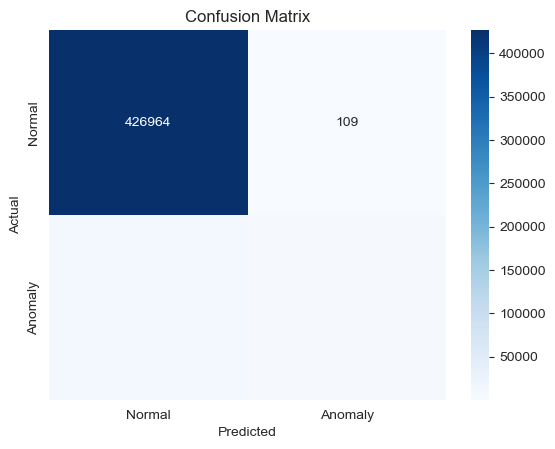

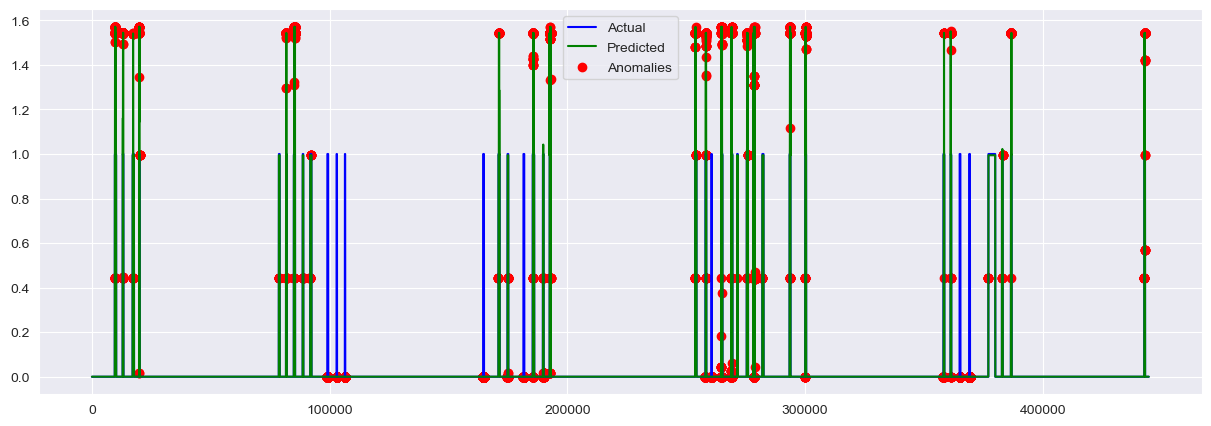

In [13]:
# 이상 탐지
anomaly_threshold = mse + 3 * np.std(predictions - test_labels.numpy().reshape(-1, 1))

anomalies = (np.abs(predictions - test_labels.numpy().reshape(-1, 1)) > anomaly_threshold).astype(int)

# Classification metrics
accuracy = accuracy_score(test_labels.numpy(), anomalies)
f1 = f1_score(test_labels.numpy(), anomalies, average='macro')
cm = confusion_matrix(test_labels.numpy(), anomalies)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 예측 및 이상치 시각화
plt.figure(figsize=(15, 5))
plt.plot(test_labels.numpy(), label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='green')
plt.scatter(np.where(anomalies == 1)[0], predictions[anomalies == 1], color='red', label='Anomalies')
plt.legend()
plt.show()